# Shark mocks

In [29]:
from astropy import constants as const
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Table
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt


In [88]:
t = Table.read('/Users/loveday/Data/4MOST/WAVES/Shark/waves_mock_catalogue_v0/waves_wide_gals.parquet')
t = t[(t['total_ab_dust_Z_VISTA'] < 21.1) * (t['zobs'] < 0.2)]
group_ids, idxs, counts = np.unique(t['id_group_sky'], return_index=True, return_counts=True)

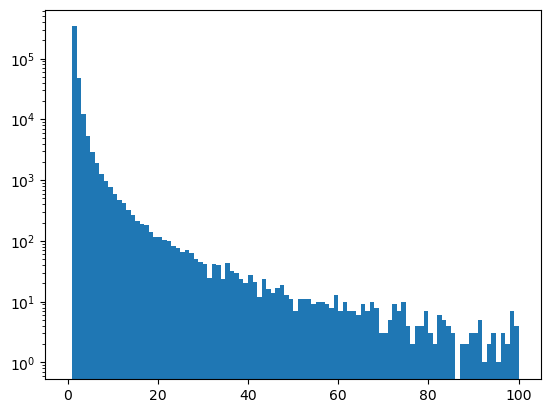

In [89]:
plt.hist(counts, bins=np.linspace(0, 100, 101))
plt.semilogy()
plt.show()

In [90]:
Nmin = 5
print(len(counts[counts >= Nmin]), 'of', len(counts), 'halos have >=', Nmin, 'members')


12393 of 414924 halos have >= 5 members


Text(0, 0.5, 'N_fof')

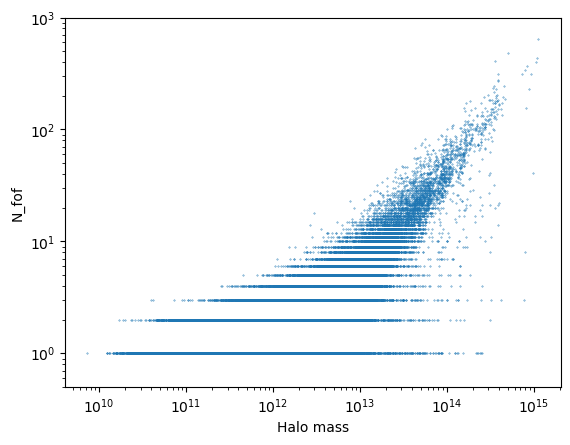

In [91]:
halo_mass = t['mvir_hosthalo'][idxs]
plt.scatter(halo_mass, counts, s=0.1)
plt.ylim(0.5, 1000)
plt.loglog()
plt.xlabel('Halo mass')
plt.ylabel('N_fof')

Text(0, 0.5, 'Frequency')

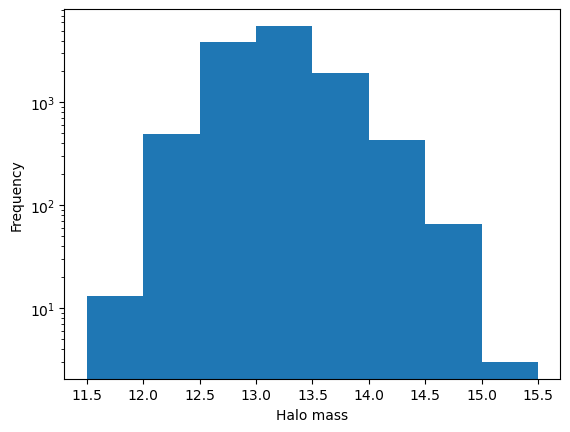

In [94]:
Nmin = 5
plt.hist(np.log10(halo_mass)[counts >= Nmin], bins=np.linspace(11.5, 15.5, 9))
plt.semilogy()
plt.xlabel('Halo mass')
plt.ylabel('Frequency')

## Dynamical masses

12392 halos have >= 5 members


Text(0, 0.5, 'Virial mass')

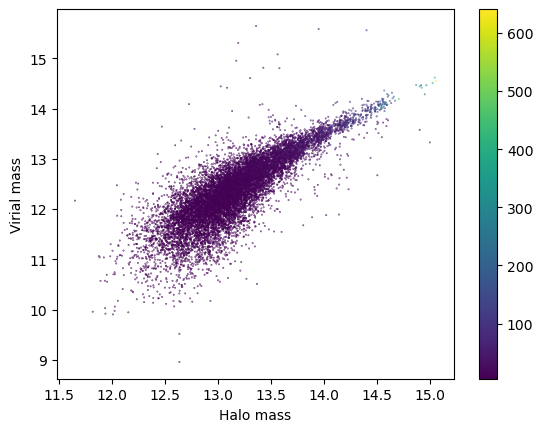

In [95]:
Nmin = 5
groups_use = group_ids[counts >= Nmin][1:]  # Remove first element = -1
print(len(groups_use), 'halos have >=', Nmin, 'members')
m_vir = np.zeros(len(groups_use))
m_halo = np.zeros(len(groups_use))
mult = np.zeros(len(groups_use))
ig = 0
for igroup in groups_use:
    group = t[t['id_group_sky'] == igroup]
    mult[ig] = len(group)
    z = group['zobs']
    ra = group['ra']
    dec = group['dec']
    gal_coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    zcen = np.average(z, weights=group['mvir_subhalo'])
    racen = np.average(ra, weights=group['mvir_subhalo'])
    deccen = np.average(dec, weights=group['mvir_subhalo'])
    group_cen = SkyCoord(ra=racen*u.degree, dec=deccen*u.degree, frame='icrs')
    ang_sep = group_cen.separation(gal_coords).to(u.radian)
    phys_sep = cosmo.angular_diameter_distance(zcen)*ang_sep.value
    R50 = np.median(phys_sep)
    sigsq = np.var(z - zcen)*const.c**2
    m_vir[ig] = (sigsq*R50/const.G).to(u.M_sun).value
    m_halo[ig] = group['mvir_hosthalo'][0]
    # print(igroup, sigsq, R50, m_vir[ig], m_halo[ig])
    ig += 1

tout = Table((groups_use, m_vir, m_halo, mult), names=('group_id', 'm_vir', 'm_halo', 'mult'))
tout.write('/Users/loveday/Data/4MOST/WAVES/Shark/waves_mock_catalogue_v0/waves_wide_group_masses.fits', overwrite=True)

plt.scatter(np.log10(tout['m_halo']), np.log10(tout['m_vir']), s=0.1, c=mult)
plt.colorbar()
plt.xlabel('Halo mass')
plt.ylabel('Virial mass')


In [74]:
t = Table((groups_use, m_vir, m_halo, mult), names=('group_id', 'm_vir', 'm_halo', 'mult'))
t.write('/Users/loveday/Data/4MOST/WAVES/Shark/waves_mock_catalogue_v0/waves_wide_group_masses.fits', overwrite=True)



11.5 12.0 13 0.0457317638858888 0.652791822202988
12.0 12.5 491 0.07294547783134021 0.50473874643486
12.5 13.0 3901 -0.02591669992544677 0.4379543265956475
13.0 13.5 5548 0.004543764830820959 0.3522141355455688
13.5 14.0 1943 0.044743574356526164 0.2460478195170443
14.0 14.5 427 -0.07768945112066714 0.27168001257774954
14.5 15.0 66 -0.20355022300866002 0.25000848838145934


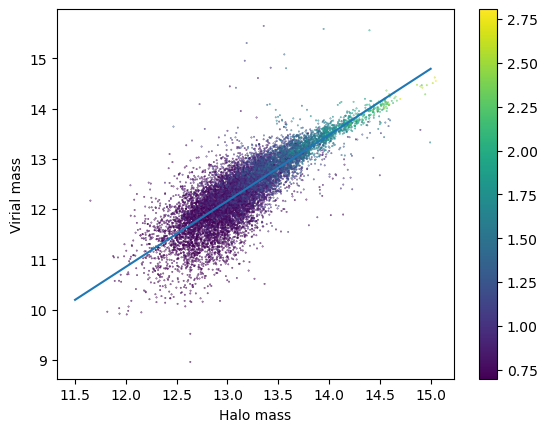

In [97]:
t = Table.read('/Users/loveday/Data/4MOST/WAVES/Shark/waves_mock_catalogue_v0/waves_wide_group_masses.fits')
lgmh = np.log10(t['m_halo'])
lgmv = np.log10(t['m_vir'])
pord = 1
p = np.polyfit(lgmh, lgmv, pord)
plt.scatter(lgmh, lgmv, s=0.1, c=np.log10(mult))
xp = [11.5, 15.0]
plt.plot(xp, np.polyval(p, xp))
plt.colorbar()
plt.xlabel('Halo mass')
plt.ylabel('Virial mass')
# bias and scatter in halo mass bins
mh_bins = np.linspace(11.5, 15.0, 8)
for imh in range(7):
    sel = (lgmh >= mh_bins[imh]) * (lgmh < mh_bins[imh+1])
    dlgm = lgmv[sel] - np.polyval(p, lgmh[sel])
    print(mh_bins[imh], mh_bins[imh+1], len(dlgm), np.mean(dlgm), np.std(dlgm))

In [58]:
print(groups_use)

print(igroup)
print(len(group))
print(ra)
print(dec)
print(group_cen)
print(gal_coords)
print(ang_sep)

  id_group_sky 
---------------
             -1
  5429600000002
  5433500000002
  5459700000001
  6158600000002
  6181400000004
  6244400000002
  6246600000002
  6252300000002
  6253000000002
            ...
109994100000006
110037100000001
110037100000002
110037100000005
110037100000011
110080100000001
110080100000002
110080100000003
110080100000005
110682100000001
Length = 67586 rows
-1
1212535
    ra   
---------
192.62422
207.56625
224.37646
191.88084
 50.18807
 48.97256
202.07242
 39.24402
 37.07024
351.18677
      ...
172.09006
356.06342
  19.4833
14.774953
  9.96514
 350.9748
186.71602
 179.8874
178.77762
341.03955
Length = 1212535 rows
   dec    
----------
 2.2340827
  2.938913
 2.2453837
-3.9216914
-30.152061
 -32.57073
 1.3453336
 -27.99464
-27.503315
-29.236376
       ...
 2.4730864
-29.207232
-31.058674
-33.728195
 -33.47404
-30.819391
-1.1555326
-2.5118215
-1.6546192
-33.066628
Length = 1212535 rows
<SkyCoord (ICRS): (ra, dec) in deg
    (166.63484192, -16.41625404)>
<SkyC

In [2]:
(16.30 + 44.70 - 39.89 +44.70 +2)/1.186

57.175379426644184

In [4]:
(17.80+13.90*4)/1.186

61.888701517706586